In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torchvision.datasets import OxfordIIITPet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Create a transform block to resize all imgs.


then

download the test and train dataset and then put it into its respective vairables

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = OxfordIIITPet(root = "data", split = "trainval", target_types = "category", transform = transform, download = True)
val_data = OxfordIIITPet(root = "data", split = "test", target_types = "category", transform = transform, download = True)

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle = False)

print(f"Number of classes: {len(train_data.classes)}")
print("Example class names:", train_data.classes[:5])


Number of classes: 37
Example class names: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle']


Loaded our resnet model and changed the final layer to match the number of classes we have(we also made sure the model uses cuda)

In [14]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_data.classes))
model = model.to(device)


Define which loss function, optimizer and what learning rate are to be used

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Define function that train the model and function checks the learning

In [6]:
def train(model, loader):
    model.train()
    running_loss = 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


Training loop for desired iterations(epochs)

In [7]:
epochs = 5
for epoch in range(epochs):
    loss = train(model, train_loader)
    acc = evaluate(model, val_loader)
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}, Val Accuracy = {acc:.4f}")


Epoch 1: Loss = 1.6101, Val Accuracy = 0.8250
Epoch 2: Loss = 0.3778, Val Accuracy = 0.8654
Epoch 3: Loss = 0.1241, Val Accuracy = 0.8757
Epoch 4: Loss = 0.0490, Val Accuracy = 0.8803
Epoch 5: Loss = 0.0252, Val Accuracy = 0.8812


Save the model

In [15]:
torch.save(model.state_dict(), "animal_breed_model.pth")


Function that resizes the input file into the format we used to train the model then adds the image with the prediction as the title

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

def show_prediction(image_path):
   
    image = Image.open(image_path).convert("RGB")
    resized_image = image.resize((224, 224)) 


    input_tensor = transform(image).unsqueeze(0).to(device)


    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        pred = train_data.classes[predicted.item()]


    plt.imshow(resized_image)
    plt.axis('off')
    plt.title(f"Prediction: {pred}")
    plt.show()


Call the above function

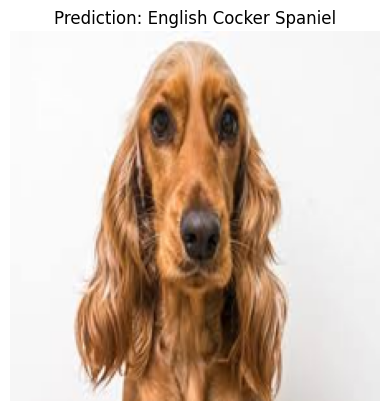

In [12]:
show_prediction(r"C:\Users\Vihas\Documents\Pytesting\pet_breed\p1.jpeg")
